# SUPERMARKET SALES

Proyecto de análisis de Series Temporales y Forecast
-- Análisis Serie Temporal - Forecast --

Jose Luis Quintero García, abr2023

## Importación de librerías y carga de datos

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [183]:
ordenes = pd.read_csv("./ordenes.csv", parse_dates=["Order Date", "Ship Date"], index_col="Order ID")
ordenes.head()

,Order Date,Ship Date,Ship Mode,Customer ID,City,Product ID,Sales,Quantity,Discount,Profit,Devolucion
Order ID,,,,,,,,,,,
CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-BO-10001798,261.9600,2,0.00,41.9136,0
CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-CH-10000454,731.9400,3,0.00,219.5820,0
CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Los Angeles,OFF-LA-10000240,14.6200,2,0.00,6.8714,0
US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Fort Lauderdale,FUR-TA-10000577,957.5775,5,0.45,-383.0310,0
US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Fort Lauderdale,OFF-ST-10000760,22.3680,2,0.20,2.5164,0


In [184]:
# Quitamos los registros donde haya una devolución
ordenes = ordenes.loc[ordenes["Devolucion"]==0]

# Borramos la columna "devolucion", que ahora sobra
ordenes.drop(["Devolucion"], axis=1, inplace=True)

In [185]:
productos = pd.read_csv("./productos.csv", index_col="Product ID")
productos.head()

,Category,Sub-Category,Product Name
Product ID,,,
FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase
FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table
OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System


Añadimos la categoría del producto a cada orden y nos quedamos solo con las órdenes de categoría "Muebles".

In [186]:
ordenes = ordenes.merge(productos, on="Product ID", how="left")[['Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'City', 'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit','Category']]
ordenes = ordenes.loc[ordenes["Category"]=="Furniture"]
ordenes.head()


,Order Date,Ship Date,Ship Mode,Customer ID,City,Product ID,Sales,Quantity,Discount,Profit,Category
0,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-BO-10001798,261.9600,2,0.00,41.9136,Furniture
1,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-CH-10000454,731.9400,3,0.00,219.5820,Furniture
3,2015-10-11,2015-10-18,Standard Class,SO-20335,Fort Lauderdale,FUR-TA-10000577,957.5775,5,0.45,-383.0310,Furniture
5,2014-06-09,2014-06-14,Standard Class,BH-11710,Los Angeles,FUR-FU-10001487,48.8600,7,0.00,14.1694,Furniture
10,2014-06-09,2014-06-14,Standard Class,BH-11710,Los Angeles,FUR-TA-10001539,1706.1840,9,0.20,85.3092,Furniture


## Análisis

El trabajo a realizar es el siguiente:

1. Expondremos los datos de ventas globales de productos en la categoría "Muebles" y haremos un análisis de la serie temporal resultante, con datos de ventas por meses.
2. Analizaremos si la serie es o no estacionaria y si presenta algún tipo de patrón de estacionalidad. 
3. Con ello determinaremos el mejor modelo para realizar un forecast de ventas durante el próximo mes.

In [187]:
ordenes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 0 to 9498
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order Date   2038 non-null   datetime64[ns]
 1   Ship Date    2038 non-null   datetime64[ns]
 2   Ship Mode    2038 non-null   object        
 3   Customer ID  2038 non-null   object        
 4   City         2038 non-null   object        
 5   Product ID   2038 non-null   object        
 6   Sales        2038 non-null   float64       
 7   Quantity     2038 non-null   int64         
 8   Discount     2038 non-null   float64       
 9   Profit       2038 non-null   float64       
 10  Category     2038 non-null   object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 191.1+ KB


In [188]:
# Primero agrupamos los pedidos por días, quedándonos solo con el dato de ventas
ordenes = ordenes \
    .groupby("Order Date").sum() \
    .sort_values("Order Date",ascending=True)
    
ordenes.head(10)

C:\Users\josel\AppData\Local\Temp\ipykernel_12204\3970474676.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby("Order Date").sum() \


,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-06,2573.820,9,0.00,746.4078
2014-01-07,153.456,6,1.20,-107.4192
2014-01-10,51.940,1,0.00,21.2954
2014-01-11,9.940,2,0.00,3.0814
2014-01-13,879.939,9,0.15,91.2798
2014-01-14,61.960,4,0.50,-53.2856
2014-01-16,127.104,6,0.20,28.5984
2014-01-19,181.470,5,0.70,-320.5970
2014-01-20,1394.210,13,0.00,270.7317


In [189]:
# Y ahora hacemos un resample para cambiar la frecuencia a mensual:
ordenes_month = ordenes.resample("M").sum()   # El valor "M" nos agrupa valores al final de cada mes
ordenes_month.head()

,Sales,Quantity,Discount,Profit
Order Date,,,,
2014-01-31,6299.953,71,3.30,745.9669
2014-02-28,1900.548,24,0.80,135.9142
2014-03-31,13439.346,126,7.85,-1184.4780
2014-04-30,8083.667,79,3.45,629.4646
2014-05-31,6777.450,100,6.30,-376.4823


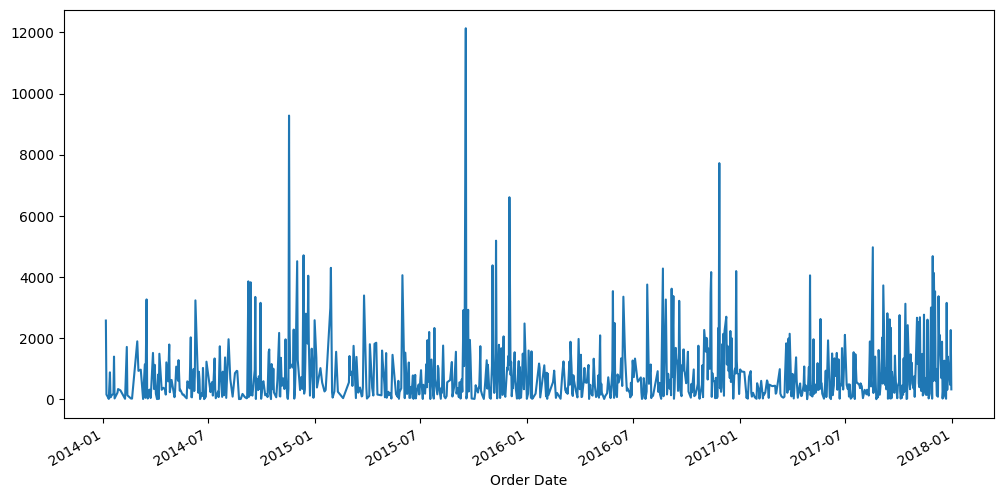

In [190]:
# Dibujamos la serie resultante en ventas
ordenes["Sales"].plot(figsize=(12,6));

Primero vemos si la serie es o no estacionaria. Para ello usamos el test Decky-Fuller

In [191]:
resultado = adfuller(ordenes_month["Sales"],autolag='AIC')
    
labels = ['Test ADF','p-value','# lags','# observaciones']
salida = pd.Series(resultado[0:4],index=labels)

for key,val in resultado[4].items():
    salida[f'Valor crítico ({key})']=val
        
print(salida.to_string())          # .to_string() removes the line "dtype: float64"
    
if resultado[1] <= 0.05:
    print("Se rechaza la hipótesis nula")
    print("La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula")
    print("La serie es no estacionaria")

Test ADF               -4.900553
p-value                 0.000035
# lags                  0.000000
# observaciones        47.000000
Valor crítico (1%)     -3.577848
Valor crítico (5%)     -2.925338
Valor crítico (10%)    -2.600774
Se rechaza la hipótesis nula
La serie es estacionaria


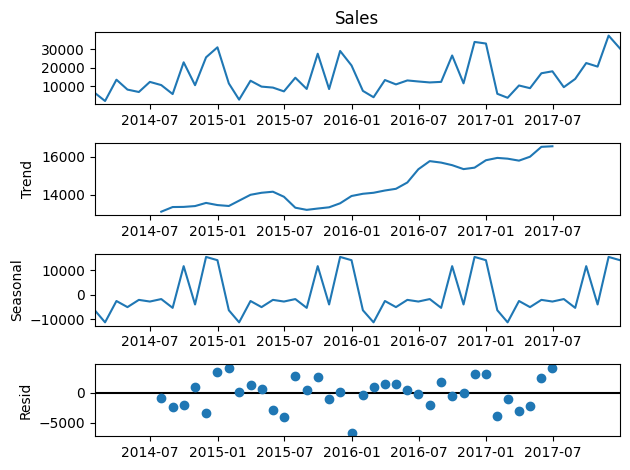

In [192]:
# Hacemos una descomposición de la estacionalidad.
seasonal_decompose(ordenes_month["Sales"], model='additive').plot();

Vemos que hay una tendencia ascendente y una clara estacionalidad. Ahora usaremos SARIMA para crear un modelo e intentar hacer un forecast.

Primero usamos auto-arima para sacar los valores p, d, q.

In [193]:
informe = auto_arima(ordenes_month['Sales'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True) 

informe.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=706.521, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=705.762, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=706.999, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=707.558, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=706.597, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=704.102, Time=0.19 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=705.168, Time=0.23 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=704.604, Time=0.23 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=707.102, Time=0.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=707.423, Time=0.09 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=708.227, Time=0.21 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=708.207, Time=0.05 sec

Best model:  ARIMA(0,0,0)(1,1,0)[12] intercept
Total fit time: 1.939 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -349.051
Date:                  Tue, 25 Apr 2023   AIC                            704.102
Time:                          20:47:08   BIC                            708.852
Sample:                      01-31-2014   HQIC                           705.760
                           - 12-31-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1867.1961    699.707      2.669      0.008     495.796    3238.597
ar.S.L12      -0.1601      0.054     -2.993      0.003      -0.265      -0.055
sigma2      1.445e+07      0.037   3.87e+08      0.000    1.45e+07    1.45e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.35   Prob(JB):                         0.60
Heteroskedasticity (H):               1.15   Skew:                             0.14
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+24. Standard errors may be unstable.
"""

Luego el modelo será con órdenes ARIMA(0,0,0)(1,1,0)[12].

Creamos el dataset de entrenamiento y el de test. Este último contendrá los valores de ventas de los últimos doce meses.

In [194]:
ordenes_train = ordenes_month["Sales"][:-12]
ordenes_train.tail()

Order Date
2016-08-31    12257.9293
2016-09-30    26542.8609
2016-10-31    11471.2290
2016-11-30    33875.1888
2016-12-31    33013.6010
Freq: M, Name: Sales, dtype: float64

In [195]:
ordenes_test = ordenes_month["Sales"][-12:]
ordenes_test

Order Date
2017-01-31     5805.5080
2017-02-28     3648.6954
2017-03-31    10304.0008
2017-04-30     8843.5605
2017-05-31    16920.5992
2017-06-30    17980.4042
2017-07-31     9389.6140
2017-08-31    13851.5880
2017-09-30    22454.7920
2017-10-31    20524.6842
2017-11-30    37306.2260
2017-12-31    30316.8210
Freq: M, Name: Sales, dtype: float64

Ahora definimos y entrenamos el modelo

In [196]:
modelo = SARIMAX(ordenes_train,order=(0,0,0), seasonal_order=(1,1,0, 12), enforce_stationarity=True,
                 enforce_invertibility=False)
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -236.134
Date:                  Tue, 25 Apr 2023   AIC                            476.268
Time:                          20:47:53   BIC                            478.624
Sample:                      01-31-2014   HQIC                           476.893
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0822      0.042     -1.938      0.053      -0.165       0.001
sigma2      1.349e+07   2.38e-10   5.66e+16      0.000    1.35e+07    1.35e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.91   Prob(JB):                         0.83
Heteroskedasticity (H):               2.28   Skew:                            -0.26
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

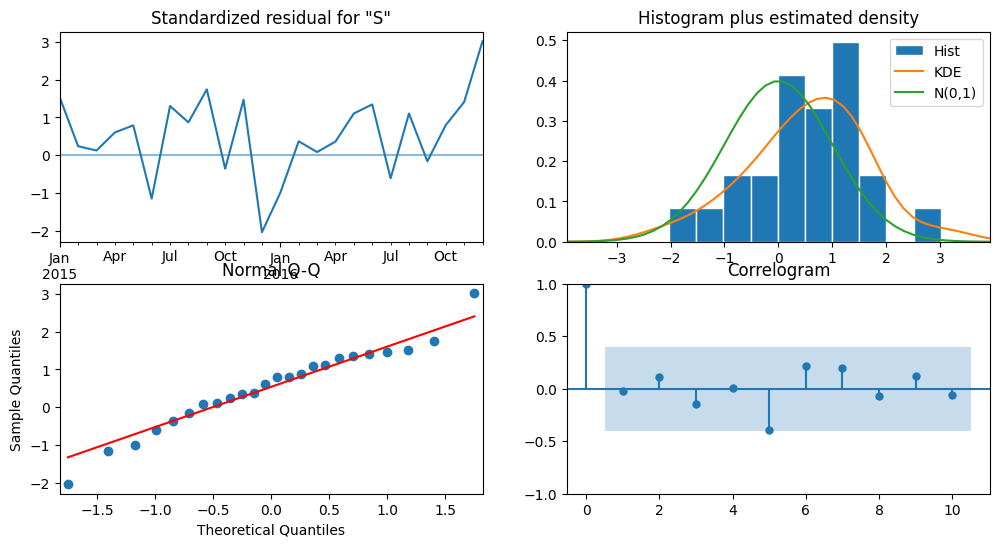

In [197]:
# Imprimimos los diagnósticos
resultado.plot_diagnostics(figsize=(12,6));

In [198]:
forecast = resultado.get_forecast(steps=12)
forecast.predicted_mean

2017-01-31     7710.538253
2017-02-28     3837.263625
2017-03-31    13221.719830
2017-04-30    10795.041498
2017-05-31    12715.166621
2017-06-30    12031.718888
2017-07-31    12159.627330
2017-08-31    11943.410550
2017-09-30    26621.178665
2017-10-31    11216.437847
2017-11-30    33473.863009
2017-12-31    32038.885487
Freq: M, Name: predicted_mean, dtype: float64

Comparamos los resultados predichos con los reales:

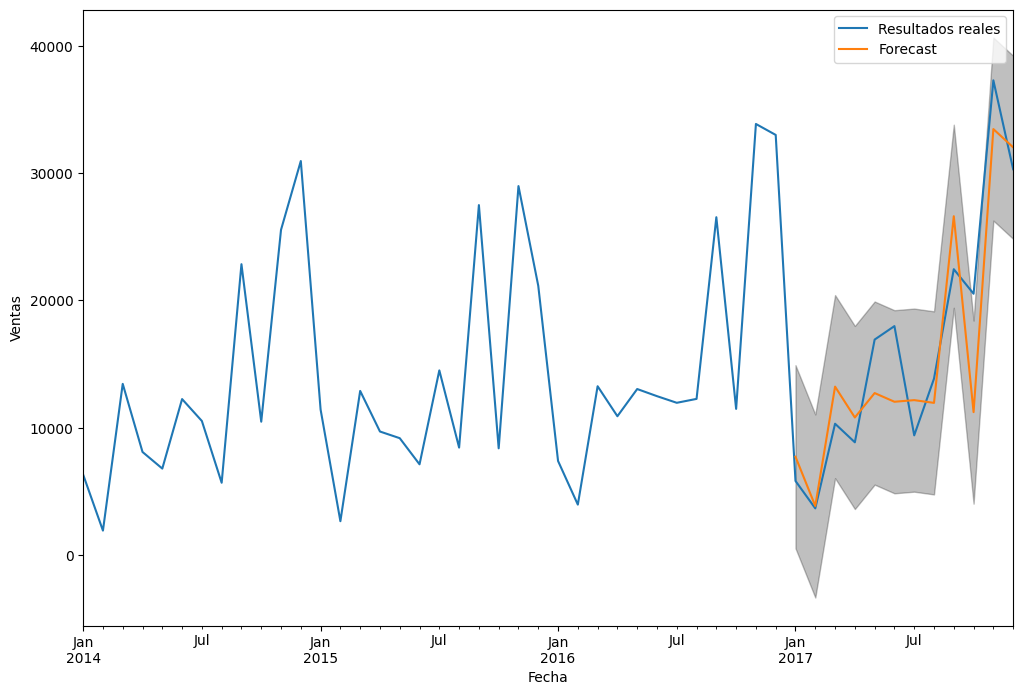

In [199]:
forecast_ci = forecast.conf_int() # Entorno de confianza de la predicción
ax = ordenes_month["Sales"].plot(label="Resultados reales", figsize=(12,8))
forecast.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas')
plt.legend()


Podemos cuantificar el error en la medida

In [201]:
reales = ordenes_month["Sales"]["2017-01-01":]
predicciones = forecast.predicted_mean
mse = ((predicciones - reales) ** 2).mean()
rmse = round(np.sqrt(mse))
media = ordenes_month["Sales"].mean()
print(f"El mse es: {mse}")
print(f"El rmse es: {rmse}")
print(f"El valor medio de la serie de ventas es: {media}")

El mse es: 16835619.66608209
El rmse es: 4103
EL valor medio de la serie de ventas es: 14667.361758333334


Si el rmse es de 4103 y el valor medio de ventas es de 14667, el error en la predicción es del 28%, lo que no es genial. En descargo de la predicción, hay que decir que en noviembre las ventas suelen caer bastante y en 2017 no cayeron apenas, lo que incrementa sustancialmente el error medio.